<a href="https://colab.research.google.com/github/khaledalics22/AUTISM_GP22/blob/khalid/FloatBoost_for_android.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download "ashwingupta3012/human-faces"

100% 1.82G/1.82G [00:19<00:00, 119MB/s]
100% 1.82G/1.82G [00:19<00:00, 99.7MB/s]


In [5]:
! unzip human-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: Humans/1 (2910).jpg     
  inflating: Humans/1 (2911).jpg     
  inflating: Humans/1 (2912).jpg     
  inflating: Humans/1 (2913).jpg     
  inflating: Humans/1 (2914).jpg     
  inflating: Humans/1 (2915).jpg     
  inflating: Humans/1 (2916).jpg     
  inflating: Humans/1 (2917).jpg     
  inflating: Humans/1 (2918).jpg     
  inflating: Humans/1 (2919).jpg     
  inflating: Humans/1 (292).jpg      
  inflating: Humans/1 (2920).jpg     
  inflating: Humans/1 (2921).jpg     
  inflating: Humans/1 (2922).jpg     
  inflating: Humans/1 (2923).jpg     
  inflating: Humans/1 (2924).jpg     
  inflating: Humans/1 (2925).jpg     
  inflating: Humans/1 (2926).jpg     
  inflating: Humans/1 (2927).jpg     
  inflating: Humans/1 (2928).jpg     
  inflating: Humans/1 (2929).jpg     
  inflating: Humans/1 (293).jpg      
  inflating: Humans/1 (2930).jpg     
  inflating: Humans/1 (2931).jpg     
  inflating: Humans/1 (2932).jpg     

In [15]:
import numpy as np 
from sklearn import svm
import sys
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
np.random.seed(220)


In [18]:
def learn_model_h(X):
    clf = svm.SVC(kernel='linear', probability= True,)
    clf.fit(X[:,:-1], X[:,-1])
    return clf


def learn_model_h_2(Z, LM, features):
    max_corr = -sys.maxsize -1 
    sel_Lk = None 
    sel_k = 0
    
    # select k* 
    for i in range(Z.shape[1] - 1):
        
        #claculate P(zk/y = 1)
        ZK = Z[:,i]
        pos_points = (ZK[Z[:,-1] == 1]).tolist()
#         print(pos_points)
        neg_points = (ZK[Z[:,-1] == -1]).tolist()
        
        log_term= []
        for zk in ZK:
            p_pos = pos_points.count(zk)
            p_neg = neg_points.count(zk)
            log_term.extend([np.log((p_pos/(p_neg+0.001))+0.001)])
            
        Lk = 0.5 * np.array(log_term)
        
        corr = np.corrcoef(Lk, LM)
        print(corr)
        # find correlation between Lk and LM
        if np.abs(corr[0,1])>max_corr:
            max_corr = np.abs(corr[0,1])
            sel_Lk = Lk
            sel_k = i
    features.extend([sel_k])
    beta = np.dot(LM.T, sel_Lk)/ np.dot(Lk.T, Lk)
    LM += beta * Lk
    return LM, features

#TODO transform X to HAAR or Integral Image
# return Z
def transform(X):
    return X

# update weights according to classifier h_m
def update_weights(preds, Y, W):
    err = np.sum(W[preds != Y])/ np.sum(W)
    if err == 0:
        return np.zeros(W.shape)
    alpha = 0.5 * np.log((1-err)/err)
    W = W * np.exp(-alpha * Y * preds).reshape(W.shape)
    
    return W/W.sum()
    

# error rate of classifier h_m 
def error_rate(preds, Y):
#     print(h_m.predict(Z[:,:-1]))
    return np.mean(preds != Y)

# calculate total_error rate
# ignore classfier at index except i
def total_error_rate(H_set, X, except_i):
    # to handle if no h in set preds will not be updated 
    # and will remain zero which is not correct since it will be assumed
    # as predictions and error rate will not be right
    if len(H_set) == 0:
        return sys.maxsize  
    # prediction based on voting of multible h
    preds = np.zeros((1,X.shape[0]))
    for i, h in enumerate(H_set):
        if except_i != None and i == except_i:
            continue
        preds = preds + (h.predict(X[:,:-1])).reshape(preds.shape)  
    #calculate error rate of voted prediction  
#     print(preds)
    return error_rate(np.where(preds[0]>0,1,-1),X[:,-1]) 

# get index of least significan classifier from classifiers set
def get_least_significant_h(H_set, X):
    err_list = [total_error_rate(H_set, X, i) for i in range(len(H_set))]
    return np.argmin(err_list)

def generate_data_set(X, W):
    idx = np.random.choice(np.arange(0,X.shape[0], 1),size = X.shape[0], p = W.flatten())
    return X[idx]

# float boost procedure
# Z training examples (x1, y1),.....,(xn, yn)
# M_max max No. of weak classifiers
# e_star acceptance threshold
def FloatBoost(X, M_max, e_star):
    N = X.shape[0]
    #initialize weights for each example 
    #shape N x 1
    W = np.ones((N, 1))
    pos_idx = [i for i in range(N) if X[i][-1] == 1]
    neg_idx = np.setdiff1d(np.arange(0, N-1, 1), pos_idx)
    a = len(pos_idx)
    b = N - a 
    W[pos_idx]= 1/(2*a)
    W[neg_idx]= 1/(2*b)
    W /= W.sum()
    
    # current No. of h trained
    M = -1
    # hypothesises set
    H_set = []
    
    # prev total error rate
    prev_tot_err_rate = sys.maxsize
    
    # Forward Inclusion
    while True: 
        M += 1
        # TODO edit this function to compute h based on W
#         print(W)
        # transform X to Z features
        Z = transform(X)
#         test_z = transform(test_x)
#          = predict(Z,test_z, LM)
#         break
        h_m = learn_model_h(X)
        #predict values 
        preds = h_m.predict(X[:,:-1])
        
        
        #update weights of examples based on chosen h
        W = update_weights(preds, X[:, -1], W)
        
        #rate of missclasified points
        err_rate = error_rate(preds, X[:,-1])
        
#         print(err_rate)
        H_set.extend([h_m])
        
        # update total error rate
        new_err_rate = total_error_rate(H_set, X, None)
        if prev_tot_err_rate > new_err_rate :
            prev_tot_err_rate = new_err_rate

        #Conditional Exclusion
        while True:
            #get least significant h (removing it causes largest decrease in total error rate)
            least_sign_h_idx = get_least_significant_h(H_set, X)
            
            temp_err = total_error_rate(H_set,X, least_sign_h_idx)
#             print(temp_err, least_sign_h_idx)
            #if least_significant h not useful remove it
            if temp_err < prev_tot_err_rate:
#                 print("remove")
                H_set.remove(H_set[least_sign_h_idx])
                prev_tot_err_rate = temp_err
                M -= 1
            else:
#                 print("No significant h")
                break
#         print(prev_tot_err_rate)
        # if max h or error rate less than threshold end
        if M == M_max or prev_tot_err_rate < e_star:
            break
        X = generate_data_set(X,W)

    return H_set
    
# predict class according to classifiers set of float boost algorithm
def predict_fboost(H_set, X):
    preds = np.zeros((1,X.shape[0]))
    for h in H_set:
         preds = preds + h.predict(X[:,:-1])
    return 100 * np.mean(np.where(preds[0] > 0, 1, -1) ==  X[:,-1]), np.where(preds[0] > 0, 1, -1)

(8, 3)
Number of classifiers selected (train set): 4
Total accuracy % 75.0
Number of classifiers selected(test set): 4
Total accuracy % 100.0


Text(0.5, 1.0, 'Actual Classes')

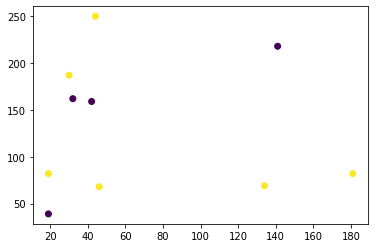

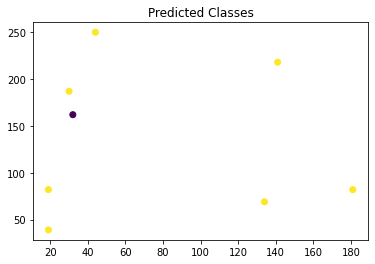

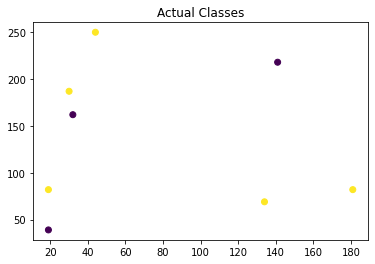

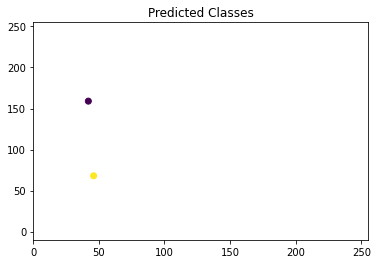

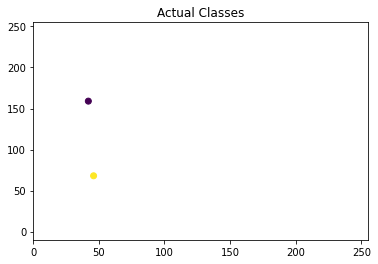

In [26]:
# test model on generated dummy dataset 
data = np.random.randint(255, size = (10, 2))
data = np.append(data, np.random.choice([-1,1],size = (10,1)), axis = 1)
data.shape

plt.figure()
plt.scatter(data[:,0],data[:,1], c = data[:,-1])

X_train, X_test = train_test_split(data, test_size=0.2)
print(X_train.shape)


H_set = FloatBoost(X_train, 10, 0.005)



acc , preds = predict_fboost(H_set, X_train)
print("Number of classifiers selected (train set):", len(H_set))
print("Total accuracy %", acc)

plt.figure()
plt.scatter(X_train[:,0],X_train[:,1], c = preds)
plt.title("Predicted Classes")

plt.figure()
plt.scatter(X_train[:,0],X_train[:,1], c = X_train[:,-1])
plt.title("Actual Classes")

acc , preds = predict_fboost(H_set, X_test)
print("Number of classifiers selected(test set):", len(H_set))
print("Total accuracy %", acc)

plt.figure()
plt.scatter(X_test[:,0],X_test[:,1], c = preds)
plt.xlim((0,255))
plt.ylim((-10,255))
plt.title("Predicted Classes")

plt.figure()
plt.scatter(X_test[:,0],X_test[:,1], c = X_test[:,-1])
plt.xlim((0,255))
plt.ylim((-10,255))
plt.title("Actual Classes")


